### Проект. Анализа лояльности пользователей Яндекса Афиши с помощь Python

Автор: Шлыков Иван

#### Цель: получить рекомендации для отдела маркетинга для увеличения конверсии новых пользователей в постоянных.

#### Задачи:
- познакомиться с данными в базе данных 
- выгрузить "сырые" данные 
- провести EDA
- сформулировать выводы
- опубликать проект в репозитории Git

In [1]:
!pip install sqlalchemy


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\ivam\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
!pip install psycopg2


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\ivam\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\ivam\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sqlalchemy import create_engine
from phik import phik_matrix
from dotenv import load_dotenv 
import os 

In [5]:
load_dotenv(dotenv_path='.env')

True

In [ ]:
db_config = dict()
db_config['user'] = os.getenv('user')
db_config['pwd'] = os.getenv('pwd')
db_config['host'] = os.getenv('host')
db_config['port'] = os.getenv('port')
db_config['db'] = os.getenv('db')
db_config

In [7]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [8]:
engine = create_engine(connection_string)

In [9]:
query = '''
WITH set_config_precode AS (
  SELECT set_config('synchronize_seqscans', 'off', true)
)
SELECT 
  p.user_id,
  p.device_type_canonical,
  p.order_id,
  p.created_dt_msk,
  p.created_ts_msk,
  p.currency_code,
  p.revenue,
  p.tickets_count,
  EXTRACT(DAY FROM (p.created_dt_msk
          - LAG(p.created_dt_msk) OVER (PARTITION BY p.user_id ORDER BY p.created_dt_msk)
         ))
AS days_since_prev,
  p.event_id,
  e.event_name_code AS event_name,
  e.event_type_main,
  p.service_name,
  r.region_name,
  c.city_name
FROM afisha.purchases AS p
LEFT JOIN afisha.events AS e ON e.event_id = p.event_id
LEFT JOIN afisha.city AS c ON c.city_id = e.city_id
LEFT JOIN afisha.regions AS r ON r.region_id = c.region_id
WHERE p.device_type_canonical IN ('mobile', 'desktop') AND e.event_type_main <> 'фильм'
ORDER BY p.user_id;
'''

In [10]:
df = pd.read_sql_query(query, con=engine)
df

,user_id,device_type_canonical,order_id,created_dt_msk,created_ts_msk,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290606,fffcd3dde79eb2c,mobile,368591,2024-10-27,2024-10-27 17:54:52,rub,965.57,4,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,Весь в билетах,Каменевский регион,Глиногорск
290607,fffcd3dde79eb2c,mobile,368562,2024-10-27,2024-10-27 17:53:53,rub,1448.36,6,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,Весь в билетах,Каменевский регион,Глиногорск
290608,fffcd3dde79eb2c,desktop,8473772,2024-10-30,2024-10-30 13:37:43,rub,178.95,2,3.0,205231,74883818-57a6-494a-b162-bb0260877cbf,театр,Прачечная,Каменевский регион,Глиногорск
290609,fffeeb3c120cf0b,desktop,5526067,2024-09-24,2024-09-24 10:07:42,rub,661.53,2,NaN,454526,6f4c6a50-0106-407b-8f54-332c740b01da,стендап,Билеты без проблем,Широковская область,Ягодиновка


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   created_dt_msk         290611 non-null  datetime64[ns]
 4   created_ts_msk         290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [12]:
df.describe(include='integer')

,order_id,tickets_count,event_id
count,2.906110e+05,290611.000000,290611.000000
mean,4.326225e+06,2.754311,438019.834992
std,2.497551e+06,1.170620,147423.078841
min,1.000000e+00,1.000000,4436.000000
25%,2.163618e+06,2.000000,361772.000000
50%,4.326366e+06,3.000000,498275.000000
75%,6.488330e+06,4.000000,546287.000000
max,8.653108e+06,57.000000,592325.000000


In [13]:
df.head(5)

,user_id,device_type_canonical,order_id,created_dt_msk,created_ts_msk,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


In [14]:
df.shape

(290611, 15)

In [15]:
df.isna().sum()

user_id                      0
device_type_canonical        0
order_id                     0
created_dt_msk               0
created_ts_msk               0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
dtype: int64

In [16]:
df.isna().mean()
# пропуски есть только в колонке dayes_since_prev

user_id                  0.000000
device_type_canonical    0.000000
order_id                 0.000000
created_dt_msk           0.000000
created_ts_msk           0.000000
currency_code            0.000000
revenue                  0.000000
tickets_count            0.000000
days_since_prev          0.075472
event_id                 0.000000
event_name               0.000000
event_type_main          0.000000
service_name             0.000000
region_name              0.000000
city_name                0.000000
dtype: float64

In [17]:
df.dtypes

user_id                          object
device_type_canonical            object
order_id                          int64
created_dt_msk           datetime64[ns]
created_ts_msk           datetime64[ns]
currency_code                    object
revenue                         float64
tickets_count                     int64
days_since_prev                 float64
event_id                          int64
event_name                       object
event_type_main                  object
service_name                     object
region_name                      object
city_name                        object
dtype: object

In [18]:
df['currency_code'].unique()

array(['rub', 'kzt'], dtype=object)

Данные соответствуют описанию:
- user_id - уникальный идентификатор пользователя
- device_type_canonical - тип устройства (mobile/desktop)
- order_id - уникальный идентификатор заказа
- created_dt_msk - дата создания заказа
- created_ts_msk - дата и время создания заказа
- currency code - валюта оплаты
- revenue - выручка от заказа
- tickets_count	 - количество купленных билетов
- days_since_prev - количество дней от предыдущей покупки пользователя,
- event_id - идентификатор мероприятия
- event_name - название мероприятия
- event_type_main - тип мероприятия
- service_name - название билетного оператора
- region_name - название региона
- city_name - наименования города  
В датасете 290 611 строк и 15 столбцов, пропущенные значения в количестве 21 933 присутствуют в столбце days_since_prev (7.5%). 

### Предобработка данных

#### Приведение к валюте рубль

In [19]:
df_currency = pd.read_csv('final_tickets_tenge_df.csv')
df_currency['data'] = pd.to_datetime(df_currency['data'],format="%Y-%m-%d", errors='coerce')
df_currency.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     357 non-null    datetime64[ns]
 1   nominal  357 non-null    int64         
 2   curs     357 non-null    float64       
 3   cdx      357 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 11.3+ KB


In [20]:

df['created_dt_msk'] = pd.to_datetime(df['created_dt_msk']).dt.date
df_currency['data'] = pd.to_datetime(df_currency['data']).dt.date

rate = df_currency.set_index('data')['curs'] #создали словарь - по дате получаем значение курса

df['revenue_rub'] = np.where( #векторное if-else
    df['currency_code'].eq('rub'), #сравнение df['currency_code'] == 'rub'
    df['revenue'], #если True - df['revenue]
    df['revenue'] * df['created_dt_msk'].map(rate) / 100 #если False ищем при помощи map - словаря и делим на 100
)
df['revenue_rub'].describe()#нет пропусков

count    290611.000000
mean        555.571987
std         875.498172
min         -90.760000
25%         113.970000
50%         351.140000
75%         802.050000
max       81174.540000
Name: revenue_rub, dtype: float64

Создали колонку revenue_rub с выручкой в рублях. В выручке присутствуют отрицательные значения.

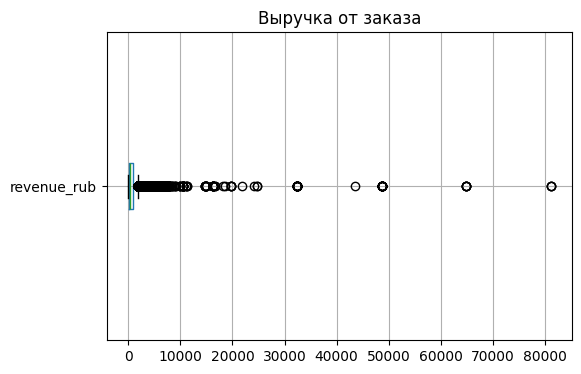

In [21]:

df.boxplot(column='revenue_rub',
           vert=False,
           figsize=(6,4))
plt.title('Выручка от заказа') # довольно много заказов с гигантской выручкой
plt.show()

#### Пропущенные значения

In [22]:
out = (df.isna()
         .agg(['sum','mean'])
         .T
         .rename(columns={'sum':'miss_abs','mean':'miss_rate'}))

out['miss_pct'] = (out['miss_rate'] * 100).round(2)
out = out.drop(columns='miss_rate')

out


,miss_abs,miss_pct
user_id,0.0,0.00
device_type_canonical,0.0,0.00
order_id,0.0,0.00
created_dt_msk,0.0,0.00
created_ts_msk,0.0,0.00
currency_code,0.0,0.00
revenue,0.0,0.00
tickets_count,0.0,0.00
days_since_prev,21933.0,7.55
event_id,0.0,0.00


Пропуски находятся в колонке 'days_since_prev' - для клиентов с одной покупкой. Количество пропусков - 21 933, 7.55%. Относительное содержание большое - не удаляю пропуски, в задании может потребоваться

#### Преобразование типов

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   created_dt_msk         290611 non-null  object        
 4   created_ts_msk         290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [24]:
df['created_dt_msk'] = df['created_dt_msk'].values.astype('datetime64[D]')
# уменьшиили размерность колонки created_dt_msk
df['tickets_count'] = pd.to_numeric(df['tickets_count'], downcast='integer') #уменьшили размерность tickets_count
df['days_since_prev'] = pd.to_numeric(df['days_since_prev'], downcast='float')


Преобразовал тип данных для created_dt_msk - datetime64[s], уменьшил размерность для tickets_count и days_since_prev

##### Проверка номинальных данных

In [25]:
df.head()

,user_id,device_type_canonical,order_id,created_dt_msk,created_ts_msk,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,1390.41


In [26]:
cols = ['device_type_canonical', 'event_type_main', 'service_name', 'region_name', 'city_name']
for i in cols:
    print(df.groupby(i).size().sort_values(ascending=True))
# выбивающихся значений не вижу

device_type_canonical
desktop     58121
mobile     232490
dtype: int64
event_type_main
ёлки          1989
выставки      4854
стендап      13393
спорт        21911
другое       65867
театр        67321
концерты    115276
dtype: int64
service_name
Билеты в интернете            4
Зе Бест!                      5
Лимоны                        8
Тех билет                    22
Цвет и билет                 61
Кино билет                   67
Дырокол                      74
Вперёд!                      80
Билет по телефону            85
Реестр                      125
КарандашРУ                  133
Телебилет                   321
Радио ticket                376
Быстрый кассир              381
Шоу начинается!             499
Росбилет                    539
Crazy ticket!               790
Восьмёрка                  1118
Выступления.ру             1616
Быстробилет                2003
Мир касс                   2167
Show_ticket                2200
Городской дом культуры     2733
За билетом!       

Проверить наличие выбросом в численных столбцах (revenue_rub и tickets_count)

count    290611.000000
mean          2.754311
std           1.170620
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64
17947


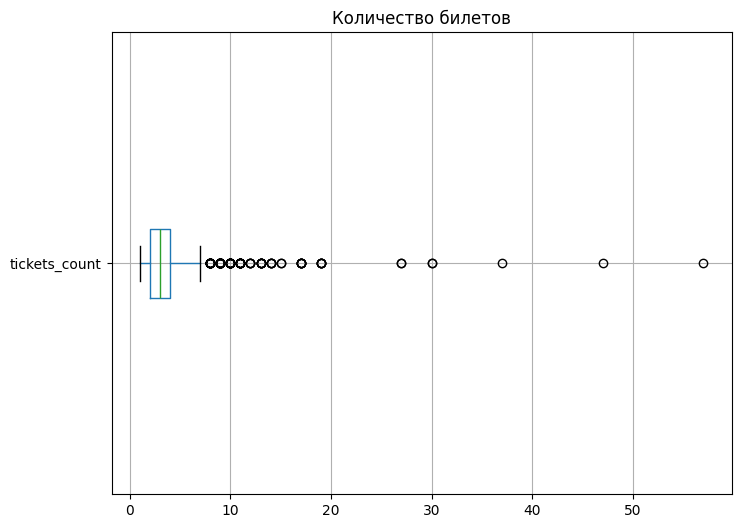

In [27]:
print(df['tickets_count'].describe())
p90 = df['tickets_count'].quantile(0.9)
count = df[df['tickets_count'] > p90].shape[0]
print(count) # довольно много значений больше 90% квантиля - 17 947
# среднее примерно равно медиане, но есть выбросы
df.boxplot(column='tickets_count', vert=False, figsize=(8,6))
plt.title('Количество билетов')
plt.show() # 

count    290611.000000
mean        555.571987
std         875.498172
min         -90.760000
25%         113.970000
50%         351.140000
75%         802.050000
max       81174.540000
Name: revenue_rub, dtype: float64
2825


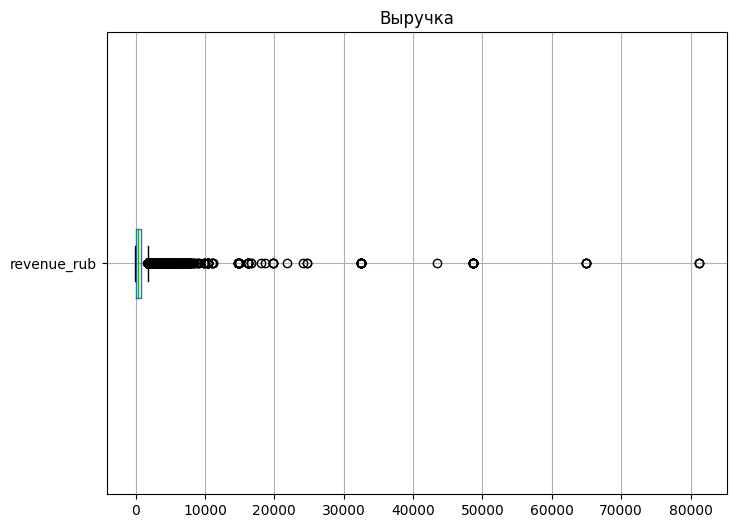

In [28]:
print(df['revenue_rub'].describe())
p99 = df['revenue_rub'].quantile(0.99)
count = df[df['revenue_rub'] > p99].shape[0]
print(count) # довольно много значений больше 99% квантиля - 2 825
# среднее примерно равно медиане, но есть выбросы
df.boxplot(column='revenue_rub', vert=False, figsize=(8,6))
plt.title('Выручка')
plt.show() # 

In [29]:
df_filt = df[df['revenue_rub'] <= p99] 
df_filt.shape[0] #профильтровали данные

287786

1) Создали колонку revenue_rub с выручкой в рублях. В выручке присутствуют отрицательные значения.
2) Пропуски находятся в колонке 'days_since_prev' - для клиентов с одной покупкой. Количество пропусков - 21 933, 7.55%. Оставил пропуски
3) Для колонки tickets_count довольно много значений больше 90% квантиля - 17 947. Оставил
4) Для колонки revenue_rub довольно много значений больше 99% квантиля - 2 825. Профильтровал - осталось 287 786 строк.

#### Создание профиля пользователя

Построение профиля пользователя

In [30]:
df_filt.columns

Index(['user_id', 'device_type_canonical', 'order_id', 'created_dt_msk',
       'created_ts_msk', 'currency_code', 'revenue', 'tickets_count',
       'days_since_prev', 'event_id', 'event_name', 'event_type_main',
       'service_name', 'region_name', 'city_name', 'revenue_rub'],
      dtype='object')

In [31]:
df_filt.groupby(['user_id','order_id']).size().describe()


count    287786.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
dtype: float64

In [32]:
df_filt = df_filt.sort_values(by=['user_id', 'created_ts_msk'],ascending=True)

df_revenue_mean = df_filt.groupby(['user_id', 'order_id'])['revenue_rub'].sum().reset_index()
df_revenue_mean = df_revenue_mean.groupby('user_id')['revenue_rub'].mean()
df_revenue_mean

user_id
0002849b70a3ce2    1521.940000
0005ca5e93f2cf4     774.010000
000898990054619     767.213333
00096d1f542ab2b     917.830000
000a55a418c128c      61.310000
                      ...     
fff13b79bd47d7c     688.043333
fff32fc9ad0f9f6     850.995000
fffcd3dde79eb2c     557.908485
fffeeb3c120cf0b     661.530000
ffff00725179321     802.250000
Name: revenue_rub, Length: 21854, dtype: float64

In [33]:
df_revenue_mean = df_filt.groupby(['user_id', 'order_id']).agg(sum_revenue=('revenue_rub', 'sum'),
                                                               sum_tickets=('tickets_count', 'sum')).reset_index()
df_revenue_mean = df_revenue_mean.groupby('user_id').agg(order_count=('order_id','count'),
                                                         mean_revenue=('sum_revenue', 'mean'),
                                                         mean_tickets=('sum_tickets', 'mean'))

In [34]:
df_filt = df_filt.sort_values(by=['user_id', 'created_ts_msk'],ascending=True)
#считаем на 1 заказ, затем усредняем на пользователя
df_revenue_mean = df_filt.groupby(['user_id', 'order_id']).agg(sum_revenue=('revenue_rub', 'sum'),
                                                               sum_tickets=('tickets_count', 'sum')).reset_index()
df_revenue_mean = df_revenue_mean.groupby('user_id').agg(order_count=('order_id','count'),
                                                         mean_revenue=('sum_revenue', 'mean'),
                                                         mean_tickets=('sum_tickets', 'mean'))
df_user = df_filt.groupby('user_id').agg(
    first_date = ('created_dt_msk', 'min'),
    last_date=('created_dt_msk', 'max')
    )
#индексы первой и последней покупки пользователя
idxmin = df_filt.groupby('user_id')['created_ts_msk'].idxmin()
idxmax = df_filt.groupby('user_id')['created_ts_msk'].idxmax()
df_first = df_filt.loc[idxmin, ['user_id', 'created_ts_msk', 'device_type_canonical', 'region_name', 'service_name', 'event_type_main']].set_index('user_id')
df_first = df_first.rename(columns={   
    'device_type_canonical':'first_device',
    'region_name':'first_region',
    'service_name':'first_service',
    'event_type_main':'first_event_type'
})
#ищем среднее время между заказами
orders_ts = (df_filt[['user_id','order_id','created_ts_msk']]
             .drop_duplicates(['user_id','order_id']) #оставляем только первое значение времени
             .sort_values(['user_id','created_ts_msk']))

avg_gap = (orders_ts.groupby('user_id')['created_ts_msk']
           .diff()
           .groupby(orders_ts['user_id'])
           .mean()
           .rename('avg_time_between_orders'))
df_user = df_user.join(df_first).join(avg_gap).join(df_revenue_mean)
df_user = df_user.drop(columns='created_ts_msk')
df_user['is_two'] = (df_user['order_count'] >= 2).astype('int')
df_user['is_five'] = (df_user['order_count'] >= 5).astype('int')
print(df_user.dtypes)
df_user.head()


first_date                   datetime64[s]
last_date                    datetime64[s]
first_device                        object
first_region                        object
first_service                       object
first_event_type                    object
avg_time_between_orders    timedelta64[ns]
order_count                          int64
mean_revenue                       float64
mean_tickets                       float64
is_two                               int64
is_five                              int64
dtype: object


,first_date,last_date,first_device,first_region,first_service,first_event_type,avg_time_between_orders,order_count,mean_revenue,mean_tickets,is_two,is_five
user_id,,,,,,,,,,,,
0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,NaT,1,1521.940000,4.000000,0,0
0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,74 days 19:19:38,2,774.010000,3.000000,1,0
000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,50 days 21:45:36,3,767.213333,2.666667,1,0
00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,NaT,1,917.830000,4.000000,0,0
000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,15 days 14:49:52,2,61.310000,1.500000,1,0


Создали таблицу профилей пользователей: 
- user_id - идентификатор пользователя
- first_date - дата первого заказа
- last_date - дата последнего заказа
- first_device - устройство, с которого был сделан первый заказ
- first_region - регион, в котором был сделан первый заказ
- first_event_type - жанр первого посещённого мероприятия
- avg_time_between_orders - среднее время между заказами
- order_count - общее число заказов
- mean_revenue - средняя выручка с одного заказа в рублях
- mean_tickets - среднее количество билетов в заказе
- is_two - совершил ли пользователь 2 и более заказа
- is_five -  совершил ли пользователь 5 и более заказов

In [35]:
print(f'Общее число пользователей: {df_user.shape[0]}')
print(f'Средняя выручка с одного заказа (на 1 пользователя):', df_user['mean_revenue'].mean())
print(f"Доля пользователей, совершивших более 2 заказов: {df_user['is_two'].mean() * 100:.2f}%")
print(f"Доля пользователей, совершивших более 5 заказов: {df_user['is_five'].mean() * 100:.2f}%")

Общее число пользователей: 21854
Средняя выручка с одного заказа (на 1 пользователя): 544.398050897431
Доля пользователей, совершивших более 2 заказов: 61.71%
Доля пользователей, совершивших более 5 заказов: 29.01%


count    21854.000000
mean        13.168573
std        121.674800
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10181.000000
Name: order_count, dtype: float64
Сколько пользователей выходят за 99% квантиль: 216
Сколько пользователей выходят за 95% квантиль: 1093


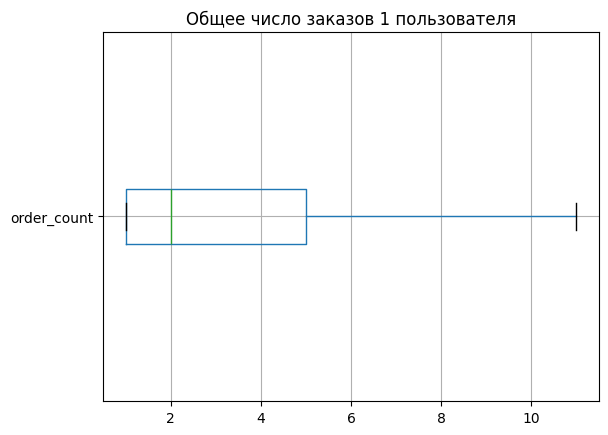

In [36]:
#общее число заказов
print(df_user['order_count'].describe()) #есть выбросы
order_99 = df_user[(df_user['order_count'] > df_user['order_count'].quantile(0.99))]
order_95 = df_user[(df_user['order_count'] > df_user['order_count'].quantile(0.95))]
print(f'Сколько пользователей выходят за 99% квантиль: {order_99.shape[0]}')
print(f'Сколько пользователей выходят за 95% квантиль: {order_95.shape[0]}')
df_user.boxplot(column='order_count',vert=False, showfliers=False) #довольно много выходит за 75%квантиль+размах
plt.title('Общее число заказов 1 пользователя')
plt.show()

count    21854.000000
mean         2.743129
std          0.913080
min          1.000000
25%          2.000000
50%          2.750000
75%          3.076923
max         11.000000
Name: mean_tickets, dtype: float64
Сколько пользователей выходят за 99% квантиль: 194
Сколько пользователей выходят за 95% квантиль: 968


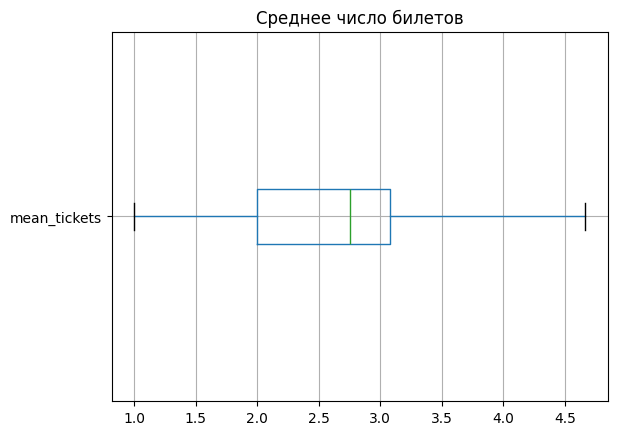

In [37]:
#среднее число билетов
print(df_user['mean_tickets'].describe()) #есть выбросы
order_99 = df_user[(df_user['mean_tickets'] > df_user['mean_tickets'].quantile(0.99))]
order_95 = df_user[(df_user['mean_tickets'] > df_user['mean_tickets'].quantile(0.95))]
print(f'Сколько пользователей выходят за 99% квантиль: {order_99.shape[0]}')
print(f'Сколько пользователей выходят за 95% квантиль: {order_95.shape[0]}')
df_user.boxplot(column='mean_tickets',vert=False, showfliers=False) #довольно много выходит за 75%квантиль+размах
plt.title('Среднее число билетов')
plt.show()

count                         13486
mean     15 days 21:05:25.652087589
std      22 days 06:29:39.596561449
min                 0 days 00:00:01
25%       1 days 00:49:28.328124999
50%          8 days 02:58:02.500000
75%      20 days 12:35:12.541666666
max               148 days 05:27:58
Name: avg_time_between_orders, dtype: object
Сколько пользователей выходят за 99% квантиль: 135
Сколько пользователей выходят за 95% квантиль: 675


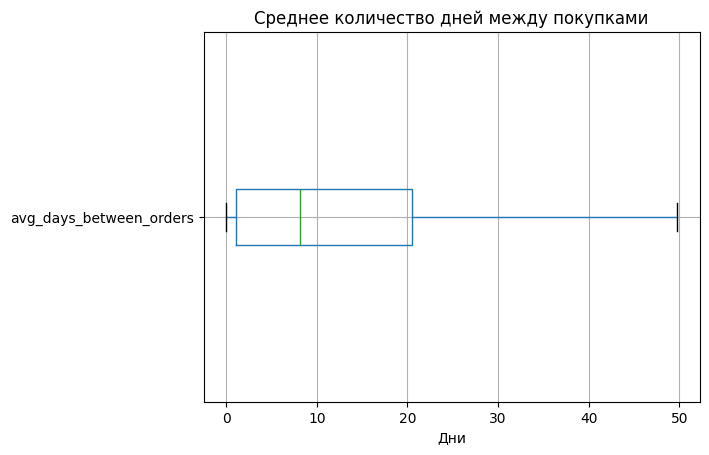

In [38]:
#среднее количество дней между покупками
print(df_user['avg_time_between_orders'].describe()) #есть выбросы
order_99 = df_user[(df_user['avg_time_between_orders'] > df_user['avg_time_between_orders'].quantile(0.99))]
order_95 = df_user[(df_user['avg_time_between_orders'] > df_user['avg_time_between_orders'].quantile(0.95))]
print(f'Сколько пользователей выходят за 99% квантиль: {order_99.shape[0]}')
print(f'Сколько пользователей выходят за 95% квантиль: {order_95.shape[0]}')
df_plot = df_user.copy()
df_plot['avg_days_between_orders'] = (
    df_plot['avg_time_between_orders'] / pd.Timedelta(days=1))
df_plot.boxplot(
    column='avg_days_between_orders',
    vert=False,
    showfliers=False)
plt.title('Среднее количество дней между покупками')
plt.xlabel('Дни')
plt.show()

По общему профилю пользователей:  
Общее число пользователей: 21854  
Средняя выручка с одного заказа (на 1 пользователя): 544.398050897431  
Доля пользователей, совершивших более 2 заказов: 61.71%  
Доля пользователей, совершивших более 5 заказов: 29.01%  
Общее число заказов:   
Сколько пользователей выходят за 99% квантиль: 216  
Сколько пользователей выходят за 95% квантиль: 1093  
Среднее число билетов:  
Сколько пользователей выходят за 99% квантиль: 194  
Сколько пользователей выходят за 95% квантиль: 968  
Среднее число дней между заказами:  
Сколько пользователей выходят за 99% квантиль: 135  
Сколько пользователей выходят за 95% квантиль: 675  

In [39]:
# посмотрю на численные параметры для клиентов, которые совершили только 1 заказ
df_one_order = df_user[df_user['avg_time_between_orders'].isna()]
print(df_one_order['mean_tickets'].describe())
print(f'Общее число пользователей: {df_one_order.shape[0]}')
print(f'Средняя выручка с одного заказа (на 1 пользователя):', df_one_order['mean_revenue'].mean())

count    8368.000000
mean        2.754541
std         1.160782
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        11.000000
Name: mean_tickets, dtype: float64
Общее число пользователей: 8368
Средняя выручка с одного заказа (на 1 пользователя): 545.2956415918619


Число клиентов, совершивших один заказ составляет 8368. По средней выручке они совпадают с выборкой из всего числа клиентов. Предлагаю убрать по общему числу заказов, среднему числу билетов пользователей, у которых по этим параметрам 99% квантиль больше

In [40]:
df_user_update = df_user[(df_user['mean_tickets'] < df_user['mean_tickets'].quantile(0.99)) &
                     (df_user['order_count'] < df_user['order_count'].quantile(0.99))].copy()
print(df_user.shape[0] - df_user_update.shape[0])
df_user_update.info()

881
<class 'pandas.core.frame.DataFrame'>
Index: 20973 entries, 0002849b70a3ce2 to ffff00725179321
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype          
---  ------                   --------------  -----          
 0   first_date               20973 non-null  datetime64[s]  
 1   last_date                20973 non-null  datetime64[s]  
 2   first_device             20973 non-null  object         
 3   first_region             20973 non-null  object         
 4   first_service            20973 non-null  object         
 5   first_event_type         20973 non-null  object         
 6   avg_time_between_orders  13142 non-null  timedelta64[ns]
 7   order_count              20973 non-null  int64          
 8   mean_revenue             20973 non-null  float64        
 9   mean_tickets             20973 non-null  float64        
 10  is_two                   20973 non-null  int64          
 11  is_five                  20973 non-null  int64          


In [41]:
print(df_user_update[['order_count','mean_tickets','mean_revenue','avg_time_between_orders']].describe())
df_user[['order_count','mean_tickets','mean_revenue','avg_time_between_orders']].describe()

        order_count  mean_tickets  mean_revenue     avg_time_between_orders
count  20973.000000  20973.000000  20973.000000                       13142
mean       6.635198      2.662940    535.429503  16 days 05:00:45.392633419
std       14.378998      0.803608    419.728755  22 days 08:45:17.784214582
min        1.000000      1.000000    -10.770000             0 days 00:00:01
25%        1.000000      2.000000    208.461667      1 days 11:36:00.303125
50%        2.000000      2.700000    460.714667   8 days 12:36:24.699999999
75%        5.000000      3.000000    758.780000  20 days 21:35:07.249999999
max      151.000000      4.833333   2628.421739           148 days 05:27:58


,order_count,mean_tickets,mean_revenue,avg_time_between_orders
count,21854.000000,21854.000000,21854.000000,13486
mean,13.168573,2.743129,544.398051,15 days 21:05:25.652087589
std,121.674800,0.913080,431.613383,22 days 06:29:39.596561449
min,1.000000,1.000000,-10.770000,0 days 00:00:01
25%,1.000000,2.000000,212.923868,1 days 00:49:28.328124999
50%,2.000000,2.750000,467.283911,8 days 02:58:02.500000
75%,5.000000,3.076923,763.910000,20 days 12:35:12.541666666
max,10181.000000,11.000000,2628.421739,148 days 05:27:58


In [42]:
print(f"Доля пользователей, совершивших более 2 заказов: {df_user_update['is_two'].mean() * 100:.2f}%")
print(f"Доля пользователей, совершивших более 5 заказов: {df_user_update['is_five'].mean() * 100:.2f}%")

Доля пользователей, совершивших более 2 заказов: 62.66%
Доля пользователей, совершивших более 5 заказов: 29.11%



После фильтрации в итоговом датафрейме df_user_update 20 973 пользователя (881 пользователей - 4% ушло).  
Средняя выручка с одного заказа (на 1 пользователя): 535  
Доля пользователей, совершивших более 2 заказов: 62.66%  
Доля пользователей, совершивших более 5 заказов: 29.11%  
Статистика по order_count: mean: 13.168573 было, стало 6.635198, медиана постоянна - 2;  
по остальным незначительные изменения.
Буду работать с df_user_update

#### Исследовательский анализ данных

По типу первого мероприятия

In [43]:
print(df_user_update['first_event_type'].value_counts())
print(df_user_update['first_event_type'].value_counts(normalize=True))

first_event_type
концерты    9370
другое      5194
театр       4101
стендап     1071
спорт        740
выставки     407
ёлки          90
Name: count, dtype: int64
first_event_type
концерты    0.446765
другое      0.247652
театр       0.195537
стендап     0.051066
спорт       0.035283
выставки    0.019406
ёлки        0.004291
Name: proportion, dtype: float64


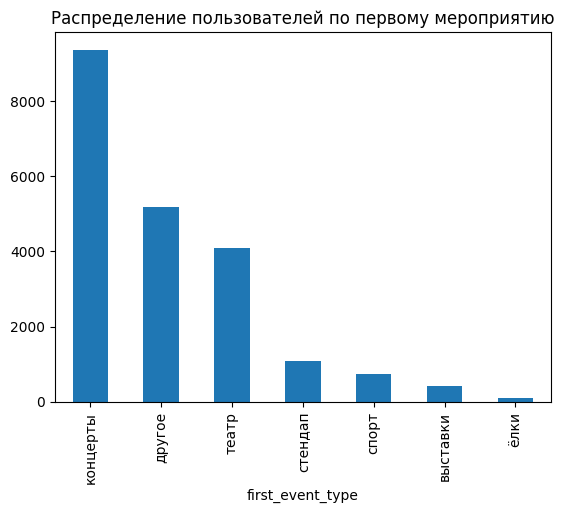

In [44]:
first_event = df_user_update.groupby('first_event_type').size().sort_values(ascending=False)
first_event.plot(kind='bar', title='Распределение пользователей по первому мероприятию')
plt.show()

По первому мероприятию выделяются концерты (9370, 45% от общего числа), группа "другое" (видимо, обобщаающее слово) - 5 194 и 25%, театр 4101 и 20% 

#### По типу устройства

In [45]:
df_user_update.columns

Index(['first_date', 'last_date', 'first_device', 'first_region',
       'first_service', 'first_event_type', 'avg_time_between_orders',
       'order_count', 'mean_revenue', 'mean_tickets', 'is_two', 'is_five'],
      dtype='object')

In [46]:
print(df_user_update['first_device'].value_counts())
print(df_user_update['first_device'].value_counts(normalize=True))

first_device
mobile     17391
desktop     3582
Name: count, dtype: int64
first_device
mobile     0.829209
desktop    0.170791
Name: proportion, dtype: float64


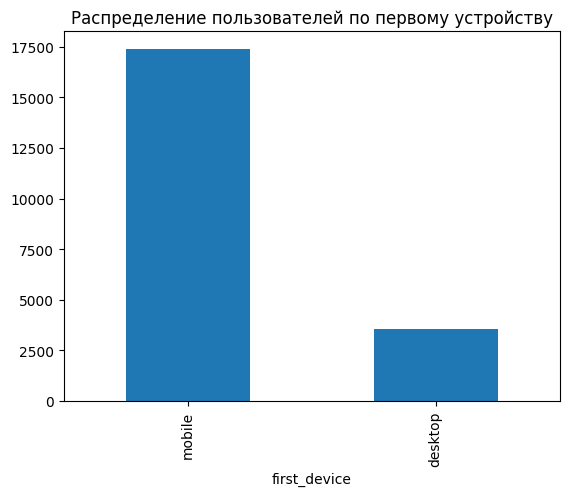

In [47]:
device = df_user_update.groupby('first_device').size().sort_values(ascending=False)
device.plot(kind='bar', title='Распределение пользователей по первому устройству')
plt.show()


83% клиентов используют мобильное устройство для первого заказа

Первый регион

In [48]:
print(df_user_update['first_region'].value_counts())
print(df_user_update['first_region'].value_counts(normalize=True))

first_region
Каменевский регион          6874
Североярская область        3621
Широковская область         1174
Озернинский край             651
Малиновоярский округ         514
                            ... 
Светолесский край              2
Тихогорская область            2
Сосноводолинская область       1
Яснопольский округ             1
Верхозёрский край              1
Name: count, Length: 81, dtype: int64
first_region
Каменевский регион          0.327755
Североярская область        0.172651
Широковская область         0.055977
Озернинский край            0.031040
Малиновоярский округ        0.024508
                              ...   
Светолесский край           0.000095
Тихогорская область         0.000095
Сосноводолинская область    0.000048
Яснопольский округ          0.000048
Верхозёрский край           0.000048
Name: proportion, Length: 81, dtype: float64


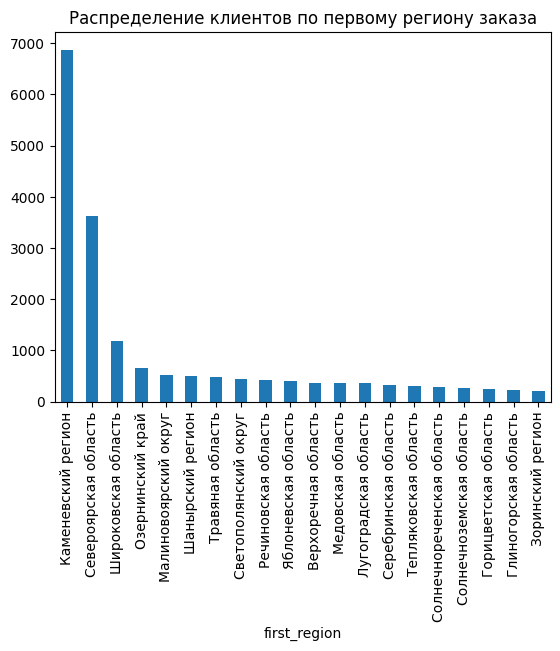

In [49]:
region = df_user_update.groupby('first_region').size().sort_values(ascending=False)

region = region[region>200]
region.plot(kind='bar', title='Распределение клиентов по первому региону заказа')
plt.show()

По первому региону выделяются:  
Каменевский регион          6874 (0.327755)   
Североярская область        3621 (0.172651)  
Широковская область         1174 (0.055977)  

In [50]:
print(df_user_update['first_service'].value_counts())

first_service
Билеты без проблем        5020
Мой билет                 2878
Лови билет!               2720
Билеты в руки             2482
Облачко                   2144
Весь в билетах            1249
Лучшие билеты             1137
Прачечная                  562
Край билетов               440
Дом культуры               342
Яблоко                     307
Тебе билет!                291
Мир касс                   205
Городской дом культуры     203
За билетом!                192
Быстробилет                156
Show_ticket                154
Выступления.ру              93
Восьмёрка                   81
Быстрый кассир              60
Crazy ticket!               44
Росбилет                    39
Радио ticket                34
Реестр                      33
Телебилет                   26
Цвет и билет                22
Шоу начинается!             19
КарандашРУ                  14
Кино билет                   9
Вперёд!                      7
Билет по телефону            5
Лимоны                   

In [51]:
print(df_user_update['first_service'].value_counts(normalize=True))

first_service
Билеты без проблем        0.239355
Мой билет                 0.137224
Лови билет!               0.129691
Билеты в руки             0.118343
Облачко                   0.102227
Весь в билетах            0.059553
Лучшие билеты             0.054213
Прачечная                 0.026796
Край билетов              0.020979
Дом культуры              0.016307
Яблоко                    0.014638
Тебе билет!               0.013875
Мир касс                  0.009774
Городской дом культуры    0.009679
За билетом!               0.009155
Быстробилет               0.007438
Show_ticket               0.007343
Выступления.ру            0.004434
Восьмёрка                 0.003862
Быстрый кассир            0.002861
Crazy ticket!             0.002098
Росбилет                  0.001860
Радио ticket              0.001621
Реестр                    0.001573
Телебилет                 0.001240
Цвет и билет              0.001049
Шоу начинается!           0.000906
КарандашРУ                0.000668
Кино б

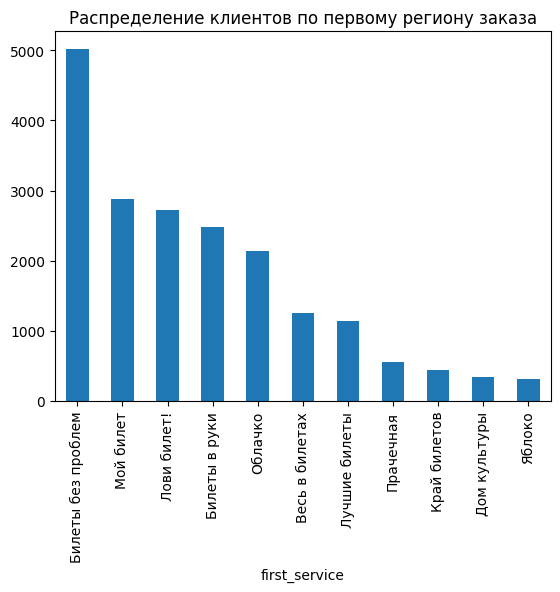

In [52]:
service = df_user_update.groupby('first_service').size().sort_values(ascending=False)

service = service[service>300]
service.plot(kind='bar', title='Распределение клиентов по первому региону заказа')
plt.show()

По билетному оператору выделяются: 
Билеты без проблем        5020 (24%)
Мой билет                 2878 (14%)
Лови билет!               2720 (13%)
Билеты в руки             2482 (12%)
Облачко                   2144 (10%)


Распределение сегментов по пользователям, совершившим 1 заказ и более 2 заказов

In [53]:
df_user_update.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20973 entries, 0002849b70a3ce2 to ffff00725179321
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype          
---  ------                   --------------  -----          
 0   first_date               20973 non-null  datetime64[s]  
 1   last_date                20973 non-null  datetime64[s]  
 2   first_device             20973 non-null  object         
 3   first_region             20973 non-null  object         
 4   first_service            20973 non-null  object         
 5   first_event_type         20973 non-null  object         
 6   avg_time_between_orders  13142 non-null  timedelta64[ns]
 7   order_count              20973 non-null  int64          
 8   mean_revenue             20973 non-null  float64        
 9   mean_tickets             20973 non-null  float64        
 10  is_two                   20973 non-null  int64          
 11  is_five                  20973 non-null  int64          
dtyp

In [54]:
df_user_update['first_event_type'].value_counts()

first_event_type
концерты    9370
другое      5194
театр       4101
стендап     1071
спорт        740
выставки     407
ёлки          90
Name: count, dtype: int64

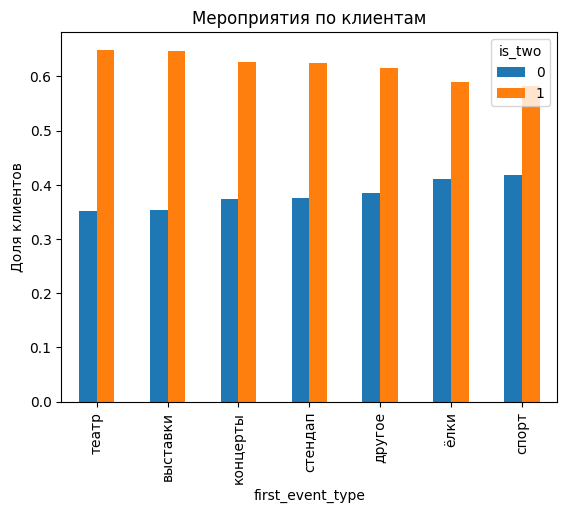

In [55]:
event_dist = df_user_update.groupby('first_event_type')['is_two'].value_counts(normalize=True).unstack().sort_values(by=0)
event_dist.plot(kind='bar', title='Мероприятия по клиентам', ylabel='Доля клиентов')
plt.show()

Для каждого типа мероприятия доля клиентов, совершивших более 1 заказа, больше доли клиентов, совершивших только 1 заказ.   
Больше всего клиентов с заказами >=2 в категориях: театр, выставки, концерты  
Больше всего клиентов, которые пользуются услугами 1 раз: спорт, ёлки (но ёлок мало - всего 90 пользователей), другое

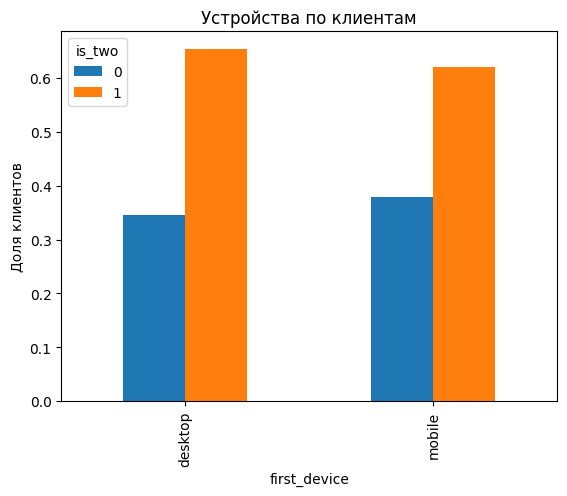

In [56]:
device_dist = df_user_update.groupby('first_device')['is_two'].value_counts(normalize=True).unstack().sort_values(by=0)
device_dist.plot(kind='bar', title='Устройства по клиентам', ylabel='Доля клиентов')
plt.show()

Клиенты, котрые используют компьютер, чаще возвращаются за новым заказом

In [57]:
df_user_update['first_region'].value_counts().head(10)

first_region
Каменевский регион      6874
Североярская область    3621
Широковская область     1174
Озернинский край         651
Малиновоярский округ     514
Шанырский регион         498
Травяная область         478
Светополянский округ     446
Речиновская область      427
Яблоневская область      399
Name: count, dtype: int64

In [58]:
top_regions = df_user_update['first_region'].value_counts().head(10).index.to_list()

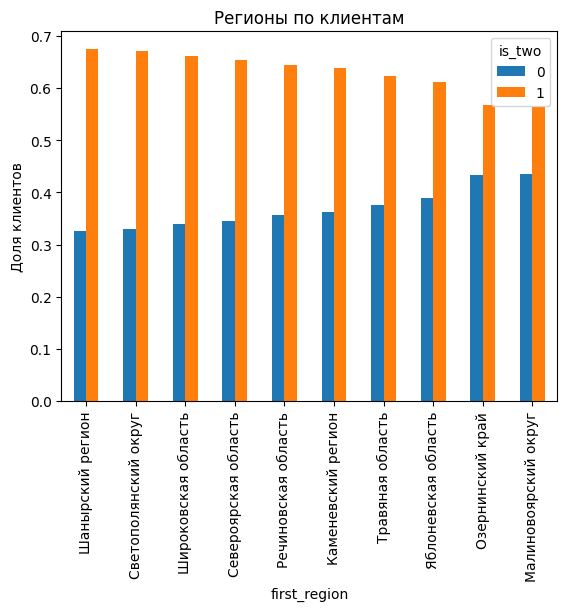

In [59]:

region_dist = df_user_update[
    df_user_update['first_region'].isin(top_regions)].groupby('first_region')[
        'is_two'].value_counts(normalize=True).unstack().sort_values(by=0)
region_dist.plot(kind='bar', title='Регионы по клиентам', ylabel='Доля клиентов')
plt.show()


По числу пользователей выделяются регионы:  
Каменевский регион      6874  
Североярская область    3621  
Широковская область     1174  
Озернинский край         651  
Малиновоярский округ     514  
Шанырский регион         498  
Травяная область         478  
Светополянский округ     446  
Речиновская область      427  
Яблоневская область      399  

Пользователей, которые совершили более 1 заказа, больше всего в Шанырском, Светополянском и Широковском регионе.  
Пользователей, которые пользовались услугами сервиса один раз, больше всего в Малиновском, Озернинском и Яблоневском регионах.

In [60]:
df_user_update['first_service'].value_counts().head(10)

first_service
Билеты без проблем    5020
Мой билет             2878
Лови билет!           2720
Билеты в руки         2482
Облачко               2144
Весь в билетах        1249
Лучшие билеты         1137
Прачечная              562
Край билетов           440
Дом культуры           342
Name: count, dtype: int64

In [61]:
top_services = df_user_update['first_service'].value_counts().head(10).index.to_list()


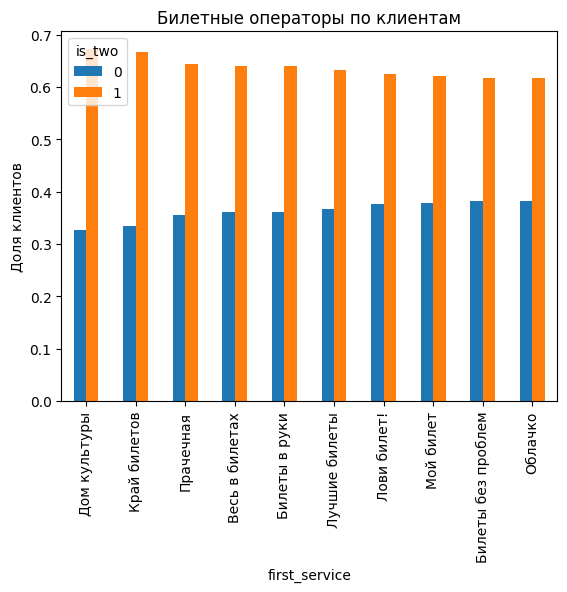

In [62]:
service_dist = df_user_update[
    df_user_update['first_service'].isin(top_services)].groupby('first_service')[
        'is_two'].value_counts(normalize=True).unstack().sort_values(by=0)
service_dist.plot(kind='bar', title='Билетные операторы по клиентам', ylabel='Доля клиентов')
plt.show()

Билетные операторы - число пользователей  
Билеты без проблем    5020  
Мой билет             2878  
Лови билет!           2720  
Билеты в руки         2482  
Облачко               2144  
Весь в билетах        1249  
Лучшие билеты         1137  
Прачечная              562  
Край билетов           440  
Дом культуры           34  

Пользователи, которые совершили более 1 заказа, использовали Край билетов, Прачечную, Весь в билетах в качестве билетного оператора. Для дома культуры мало пользователей, лучше его не учитывать
Пользователей, которые пользовались услугами сервиса один раз, использовали Облачко, Билеты без проблем, Мой билет в качестве билетного оператора. Нужно обратить внимание, что для лидеров билетных операторов наблюдается много пользователей, совершивших 1 заказ: Билеты без проблем, Мой билет, Лови билет!   

#### Проверка гипотез

Гипотеза 1. Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
Нет, гипотеза неверна. Пользователи, которые делают первый заказ на концерт, делают повторный заказ чаще, чем на спорт.

Гипотеза 2. В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.
Строго нельзя сказать, что есть монотонная зависимость: чем больше клиентов в регионе - тем больше повторных заказов. 
Пользователей, которые совершили более 1 заказа, больше всего в Шанырском, Светополянском и Широковском регионе. Они не находятся в топе по числу клиентов.

#### Исследование поведения пользователей через показатели выручки и состава заказа

In [63]:
# Проследите связь между средней выручкой сервиса с заказа и повторными заказами.
df_user_update.columns

Index(['first_date', 'last_date', 'first_device', 'first_region',
       'first_service', 'first_event_type', 'avg_time_between_orders',
       'order_count', 'mean_revenue', 'mean_tickets', 'is_two', 'is_five'],
      dtype='object')

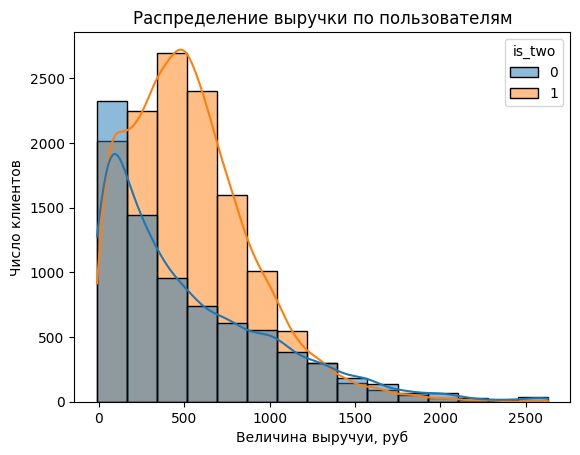

In [64]:
revenue_dist = df_user_update.groupby('is_two')['mean_revenue']
sns.histplot(data=df_user_update, x='mean_revenue', bins=15, kde=True, hue='is_two')
plt.title('Распределение выручки по пользователям')
plt.ylabel('Число клиентов')
plt.xlabel('Величина выручуи, руб')
plt.show()

In [65]:
df_user_update.groupby('is_two')['mean_revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
is_two,,,,,,,,
0,7831.0,526.511046,499.575164,-10.770,126.095000,367.700000,798.525000,2628.421739
1,13142.0,540.743796,363.831152,-5.385,270.186875,494.432619,741.350746,2628.421739


Вернувшиеся пользователи (2+ заказов):
- Основной диапазон — 250–700 руб
- Медиана = 494 руб
- 75% пользователей — до 740   
Хвост есть, но менее выражен  
средний чек выше и стабильнее  

Пользователи с одним заказом  
- Основная масса — 100–500 руб  
- Медиана ≈ 368 руб   
- 75% пользователей — до 800 руб  
- длинный правый хвост  
низко- и среднечековые заказы  

Пользователи с более высокой средней выручкой за заказ чаще совершают повторные покупки.

In [66]:
more_than_1 = df_user_update[(df_user_update['is_two'] == 1)].copy()
more_than_1['two_to_five'] = (more_than_1['is_five']==1).astype('int')
more_than_1.groupby('two_to_five')['mean_revenue'].describe()


,count,mean,std,min,25%,50%,75%,max
two_to_five,,,,,,,,
0,7036.0,545.854315,413.123719,-5.385,217.422500,467.870000,792.232500,2628.421739
1,6106.0,534.854899,296.981137,0.000,330.372038,512.066404,700.229036,2299.869022


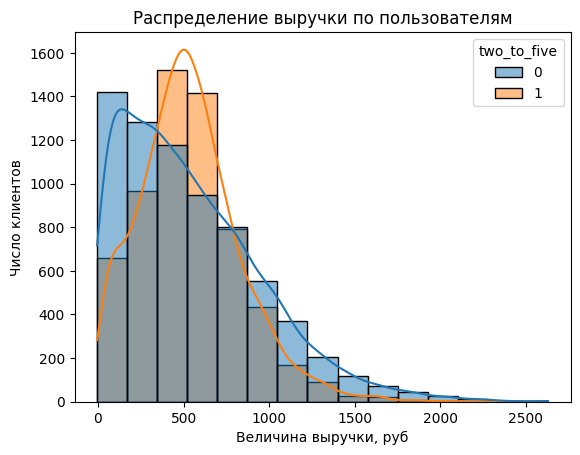

In [67]:
sns.histplot(data=more_than_1, x='mean_revenue', bins=15, kde=True, hue='two_to_five')
plt.title('Распределение выручки по пользователям')
plt.ylabel('Число клиентов')
plt.xlabel('Величина выручки, руб')
plt.show()

Группа 0 (two_to_five = 0) — пользователи с 2–4 заказами  
Группа 1 (two_to_five = 1) — пользователи с 5 и более заказами   
- Пользователи с 2–4 заказами     
Основной диапазон: ~200–800 руб    
Медиана ≈ 468 руб    
Среднее ≈ 546 руб  
Распределение с длинным правым хвостом    
Большой разброс (std ≈ 413 руб)  
- Пользователи с 5+ заказами  
Основной диапазон: ~330–700 руб  
Медиана ≈ 512 руб    
Среднее ≈ 535 руб  
Распределение более узкое и стабильное  
Разброс меньше (std ≈ 297 руб)  

Различия между группами присутствуют: пользователи с 5+ заказами имеют более стабильную и несколько более высокую типичную среднюю выручку с заказа, однако существенного различия по среднему значению не наблюдается.

Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

In [68]:
df_user_update.columns

Index(['first_date', 'last_date', 'first_device', 'first_region',
       'first_service', 'first_event_type', 'avg_time_between_orders',
       'order_count', 'mean_revenue', 'mean_tickets', 'is_two', 'is_five'],
      dtype='object')

In [69]:
df_user_update['mean_tickets'].describe()

count    20973.000000
mean         2.662940
std          0.803608
min          1.000000
25%          2.000000
50%          2.700000
75%          3.000000
max          4.833333
Name: mean_tickets, dtype: float64

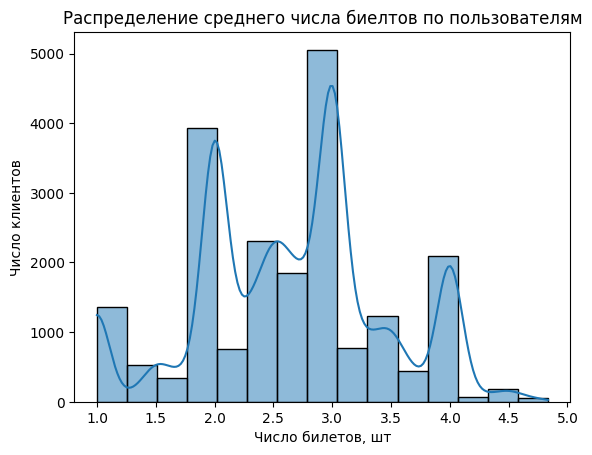

In [70]:
sns.histplot(data=df_user_update, x='mean_tickets', bins=15, kde=True)
plt.title('Распределение среднего числа биелтов по пользователям')
plt.ylabel('Число клиентов')
plt.xlabel('Число билетов, шт')
plt.show()

Мультимодальное распределение, чаще всего покупают ~3 билета.

In [71]:
df_user_update.columns

Index(['first_date', 'last_date', 'first_device', 'first_region',
       'first_service', 'first_event_type', 'avg_time_between_orders',
       'order_count', 'mean_revenue', 'mean_tickets', 'is_two', 'is_five'],
      dtype='object')

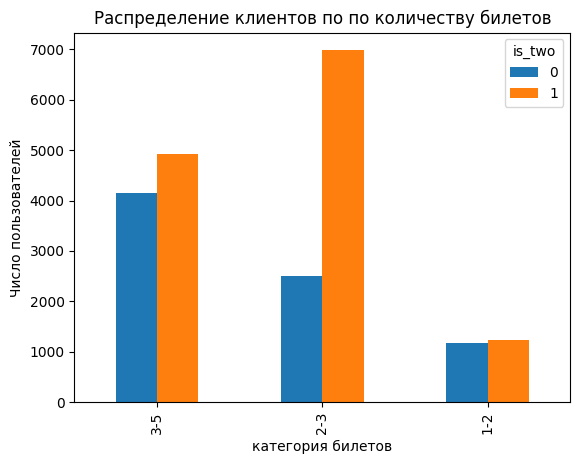

In [72]:
#создам новый столбец с категориями для числа билетов
def classify(row):
    if row['mean_tickets'] >= 1 and row['mean_tickets'] < 2:
        return '1-2'
    elif row['mean_tickets'] >= 2 and row['mean_tickets'] <3:
        return '2-3'
    elif row['mean_tickets'] >= 3 and row['mean_tickets'] <5:
        return '3-5'
#категорию 5+ не создавал - её профильтровал
df_user_update['ticket_class'] = df_user_update.apply(classify, axis=1)
ticket_abs = df_user_update.groupby('ticket_class')['is_two'].value_counts().unstack().sort_values(by=0, ascending=False)
ticket_abs.plot(kind='bar',ylabel='Число пользователей', xlabel='категория билетов')
plt.title('Распределение клиентов по по количеству билетов')
plt.show()

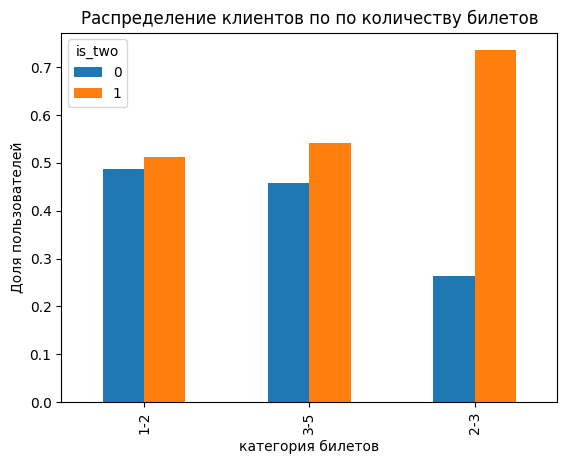

In [73]:
ticket_rel = df_user_update.groupby('ticket_class')['is_two'].value_counts(normalize=True).unstack().sort_values(by=0, ascending=False)
ticket_rel.plot(kind='bar',ylabel='Доля пользователей', xlabel='категория билетов')
plt.title('Распределение клиентов по по количеству билетов')
plt.show()

In [74]:
df_user_update.groupby('ticket_class')['is_two'].value_counts()

ticket_class  is_two
1-2           1         1241
              0         1178
2-3           1         6985
              0         2509
3-5           1         4916
              0         4144
Name: count, dtype: int64

In [75]:
df_user_update.groupby('ticket_class')['is_two'].value_counts(normalize=True)

ticket_class  is_two
1-2           1         0.513022
              0         0.486978
2-3           1         0.735728
              0         0.264272
3-5           1         0.542605
              0         0.457395
Name: proportion, dtype: float64

Пользователи распределены по среднему числу билетов неравномерно. 
Основная масса сконцентрирована в сегментах: 2–3 билета, 3–5 билетов.  
Сегмент 1–2 билета заметно меньше
Самая высокая доля повторных покупок для сегмента 2-3 билета (74%). В остальных категориях незначительные различия. Среднее количество билетов в заказе связано с вероятностью повторной покупки, однако зависимость носит нелинейный характер.

#### Исследование временных характеристик первого заказа и их влияния на повторные покупки

In [76]:
df_user_update.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20973 entries, 0002849b70a3ce2 to ffff00725179321
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype          
---  ------                   --------------  -----          
 0   first_date               20973 non-null  datetime64[s]  
 1   last_date                20973 non-null  datetime64[s]  
 2   first_device             20973 non-null  object         
 3   first_region             20973 non-null  object         
 4   first_service            20973 non-null  object         
 5   first_event_type         20973 non-null  object         
 6   avg_time_between_orders  13142 non-null  timedelta64[ns]
 7   order_count              20973 non-null  int64          
 8   mean_revenue             20973 non-null  float64        
 9   mean_tickets             20973 non-null  float64        
 10  is_two                   20973 non-null  int64          
 11  is_five                  20973 non-null  int64          
 12 

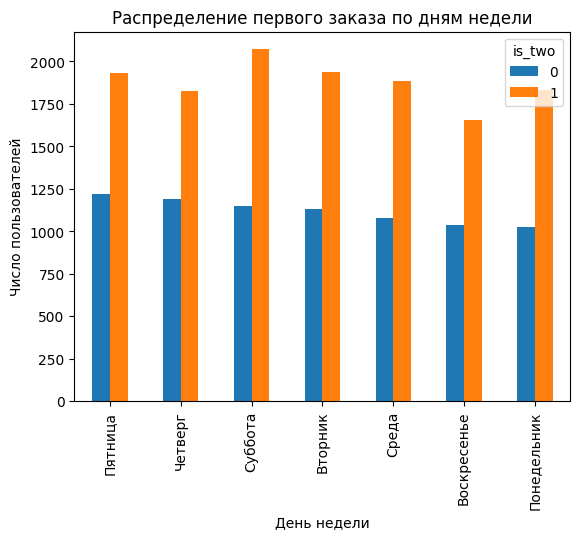

In [77]:
#день недели первой покупки
day_map = {
    0: 'Понедельник',
    1: 'Вторник',
    2: 'Среда',
    3: 'Четверг',
    4: 'Пятница',
    5: 'Суббота',
    6: 'Воскресенье'
}
df_user_update['day_of_week'] = (
    df_user_update['first_date']
    .dt.dayofweek
    .map(day_map) #для облегчения восприятия
)

group_by_weekday_abs = df_user_update.groupby('day_of_week')['is_two'].value_counts().unstack().sort_values(by=0, ascending=False)
group_by_weekday_abs.plot(kind='bar', ylabel='Число пользователей', xlabel='День недели')
plt.title('Распределение первого заказа по дням недели')
plt.show()

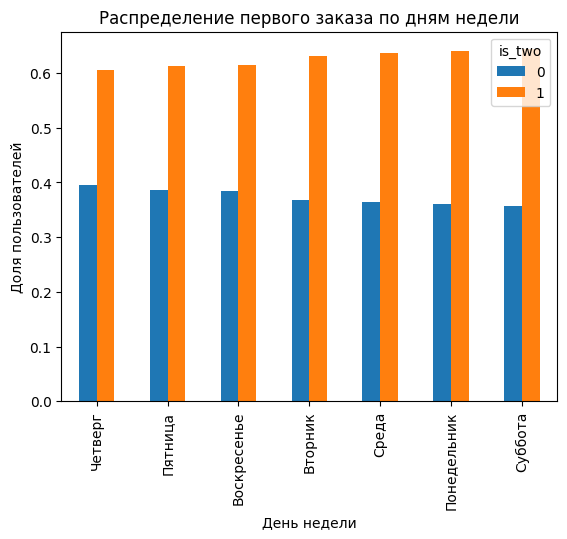

In [78]:
group_by_weekday_rel = df_user_update.groupby('day_of_week')['is_two'].value_counts(normalize=True).unstack().sort_values(by=0, ascending=False)
group_by_weekday_rel.plot(kind='bar', ylabel='Доля пользователей', xlabel='День недели')
plt.title('Распределение первого заказа по дням недели')
plt.show()

In [79]:
df_user_update.groupby('day_of_week')['is_two'].value_counts(normalize=True).unstack().sort_values(by=0, ascending=False)

is_two,0,1
day_of_week,,
Четверг,0.394772,0.605228
Пятница,0.386667,0.613333
Воскресенье,0.384987,0.615013
Вторник,0.368112,0.631888
Среда,0.363912,0.636088
Понедельник,0.359692,0.640308
Суббота,0.356522,0.643478


In [80]:
df_user_update.groupby('day_of_week')['is_two'].value_counts().unstack().sort_values(by=0, ascending=False)

is_two,0,1
day_of_week,,
Пятница,1218,1932
Четверг,1193,1829
Суббота,1148,2072
Вторник,1129,1938
Среда,1079,1886
Воскресенье,1036,1655
Понедельник,1028,1830


По абсолютным значениям:   
Число пользователей, совершивших первый заказ, довольно равномерно распределено по дням недели. Нет резких пиков. День недели не сильно влияет на сам факт совершения первого заказа.  
Доля повторных заказов изменяется в интервале от 60% до 64%. Небольшой рост доли повторных заказов наблюдается у пользователей, пришедших в начале недели и в субботу  
День недели, в который была совершена первая покупка, оказывает слабое влияние на вероятность повторной покупки.

#### Изучите, как средний интервал между заказами влияет на удержание клиентов.

In [81]:
df_user_update.columns

Index(['first_date', 'last_date', 'first_device', 'first_region',
       'first_service', 'first_event_type', 'avg_time_between_orders',
       'order_count', 'mean_revenue', 'mean_tickets', 'is_two', 'is_five',
       'ticket_class', 'day_of_week'],
      dtype='object')

In [82]:
#сделаю категоризацию по числу заказов
def classify_order(row):
    if row['order_count'] == 1:
        return '1'
    elif row['order_count'] >= 2 and row['order_count'] < 5:
        return '2-4'
    else:
        return '>=5'
df_user_update['order_class'] = df_user_update.apply(classify_order, axis=1)
df_user_update['order_class'].value_counts()    

order_class
1      7831
2-4    7036
>=5    6106
Name: count, dtype: int64

In [83]:
df_user_update.groupby('order_class')['avg_time_between_orders'].mean()

order_class
1                            NaT
2-4   21 days 14:34:03.065141178
>=5    9 days 23:43:31.061849830
Name: avg_time_between_orders, dtype: timedelta64[ns]

In [84]:
df_user_update.groupby('order_class')['avg_time_between_orders'].describe()

,count,mean,std,min,25%,50%,75%,max
order_class,,,,,,,,
1,0,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2-4,7036,21 days 14:34:03.065141178,28 days 14:31:14.454404687,0 days 00:00:01,0 days 00:11:26.249999999,9 days 11:16:14,34 days 05:22:43.750000,148 days 05:27:58
>=5,6106,9 days 23:43:31.061849831,7 days 20:09:48.635874802,0 days 00:00:29.714285714,3 days 22:16:30.190789473,8 days 05:32:41.199346405,14 days 06:28:56.482142856,37 days 08:56:27.250000


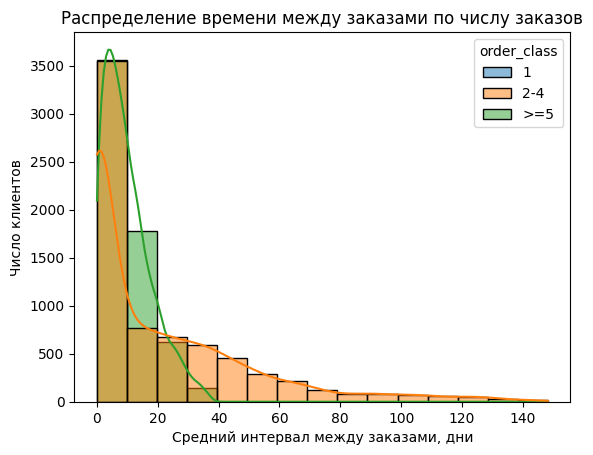

In [85]:
# sns плохо работает с timdelta - делают float

df_user_update['avg_days_between_orders'] = (
    df_user_update['avg_time_between_orders'] / pd.Timedelta(days=1)
)

sns.histplot(
    data=df_user_update,
    x='avg_days_between_orders',
    bins=15,
    kde=True,
    hue='order_class'
)

plt.title('Распределение времени между заказами по числу заказов')
plt.ylabel('Число клиентов')
plt.xlabel('Средний интервал между заказами, дни')
plt.show()


Пользователи с 2–4 заказами    
Средний интервал: ~21 день   
Медиана: ~9 дней   
75% пользователей: до ~34 дней   
Максимум: ~148 дней    
Большой разброс (std ≈ 28 дней)   
Есть как частые, так и редкие повторные покупки  
Длинный «хвост» редких заказов  

Пользователи с 5+ заказами  
Средний интервал: ~9 дней  
Медиана: ~8 дней  
75% пользователей: до ~14 дней  
Максимум: ~37 дней  
Разброс существенно меньше    
Поведение более стабильное и предсказуемое  

Для интервала между заказами наблюдается зависимость от числа заказов.  
Для пользователей, совершивших 2–4 заказа, средний интервал между заказами составляет около 21 дня и характеризуется большим разбросом значений, что указывает на нерегулярное поведение клиентов. В то же время пользователи с 5 и более заказами имеют зболее стабильный интервал между покупками — в среднем около 9 дней, с медианным значением около 8 дней. Таким образом, меньший средний интервал между заказами связан с более высокой вероятностью повторных покупок и более высоким уровнем удержания клиентов.

#### Корреляционный анализ

In [86]:
df_user_update['order_count'].value_counts().sort_values(ascending=False)

order_count
1      7831
2      3497
3      2148
4      1391
5       968
       ... 
116       1
103       1
108       1
147       1
89        1
Name: count, Length: 147, dtype: int64

In [87]:
# Вычисляем корреляционную матрицу с использованием phi_k
correlation_matrix = df_user_update[['first_device', 'first_region', 'first_service',
                         'first_event_type', 'avg_days_between_orders', 'mean_revenue', 'mean_tickets',
                         'ticket_class', 'day_of_week', 'order_count']].phik_matrix()

# Выводим результат
print('Корреляционная матрица с коэффициентом phi_k для переменной order_count')
correlation_matrix.loc[correlation_matrix.index != 'order_count'][['order_count']].sort_values(by='order_count', ascending=False)

interval columns not set, guessing: ['avg_days_between_orders', 'mean_revenue', 'mean_tickets', 'order_count']
Корреляционная матрица с коэффициентом phi_k для переменной order_count


,order_count
mean_tickets,0.383635
avg_days_between_orders,0.300413
ticket_class,0.242196
mean_revenue,0.222657
first_region,0.121579
day_of_week,0.058899
first_service,0.032360
first_event_type,0.029309
first_device,0.026735


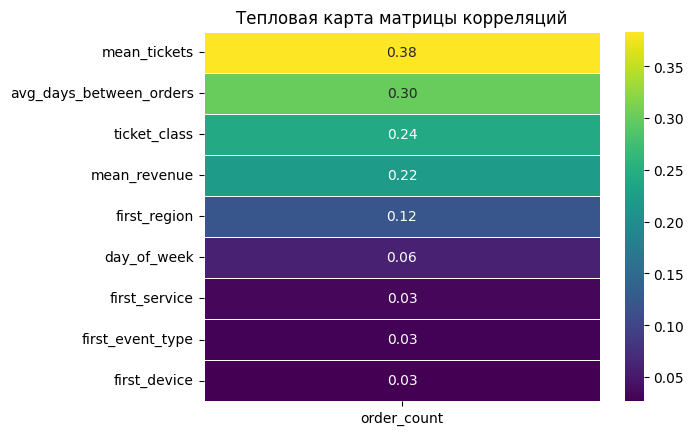

In [88]:

sns.heatmap(data=correlation_matrix.loc[correlation_matrix.index != 'order_count'][
    ['order_count']].sort_values(by='order_count', ascending=False),
             annot=True,
            fmt='.2f',
            linewidths=0.5,
            cmap='viridis')
plt.title('Тепловая карта матрицы корреляций')
plt.show()

In [89]:
# Вычисляем корреляционную матрицу с использованием phi_k
correlation_matrix_order_class = df_user_update[['first_device', 'first_region', 'first_service',
                         'first_event_type', 'avg_days_between_orders', 'mean_revenue', 'mean_tickets',
                         'ticket_class', 'day_of_week', 'order_class']].phik_matrix()

# Выводим результат
print('Корреляционная матрица с коэффициентом phi_k для переменной order_class')
correlation_matrix_order_class.loc[correlation_matrix_order_class.index != 'order_class'][
    ['order_class']].sort_values(by='order_class', ascending=False)

interval columns not set, guessing: ['avg_days_between_orders', 'mean_revenue', 'mean_tickets']
Корреляционная матрица с коэффициентом phi_k для переменной order_class


,order_class
mean_tickets,0.656859
ticket_class,0.472735
avg_days_between_orders,0.469807
mean_revenue,0.322618
first_region,0.125345
first_service,0.079096
first_event_type,0.035404
day_of_week,0.034575
first_device,0.018444


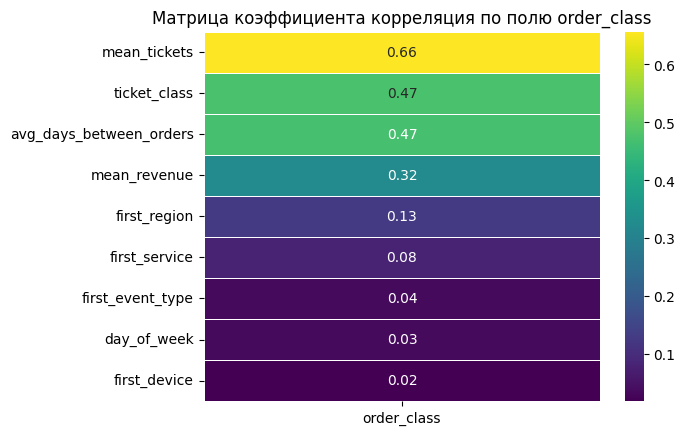

In [90]:
sns.heatmap(data=correlation_matrix_order_class.loc[correlation_matrix_order_class.index != 'order_class'][
    ['order_class']].sort_values(by='order_class', ascending=False),
    annot=True,
    fmt='.2f',
    linewidths=0.5,
    cmap='viridis')
plt.title('Матрица коэффициента корреляция по полю order_class')
plt.show()

В данных: сильно преобладает сегмент 1 заказ, поэтому лучше использовать сегментацию по числу заказов: 1, 2-4 и >=5 для оценки зависимости числа заказов от других признаков.   
Наиболее значимые признаки: среднее количество билетов в заказе (сильная связь с ростом числа заказов - пользователи с большими заказами чаще возвращаются), средний интервал между заказами - чем короче интервал, тем выше вероятность перехода в сегмент 5+  
Наиболее сильную связь с количеством заказов демонстрируют поведение пользователей: среднее число билетов в заказе и средний интервал между заказами. Характеристики первого контакта с сервисом (устройство, сервис, день недели, тип события) имеют слабую или отсутствующую связь с количеством заказов. Сегментация пользователей по числу заказов позволила выявить более выраженные зависимости, что указывает на ограниченность корреляционного анализа при доминировании одного значения в целевой переменной.

#### Общие выводы

В ходе работы над проектом был проанализирован пользовательский датасет сервиса продажи билетов  
В ходе подготовки данных были выполнены следующие шаги:  
проведена фильтрация и агрегация данных на уровне пользователя;  
выручку переведены в рубли;
рассчитаны пользовательские метрики:  
- средняя выручка с заказа, среднее число билетов в заказе, средний интервал между заказами;  
- обработаны выбросы и пропущенные значения;
- пользователи сегментированы по числу заказов (1, 2–4, 5+), а также по среднему количеству билетов;  
для анализа зависимостей использован коэффициент корреляции phi_k, корректный для смешанных типов данных.  
  
Общая характеристика пользователей  
В выборке представлено несколько десятков тысяч пользователей.  
Распределение по числу заказов сильно скошено:  
значительная доля пользователей совершает только один заказ;  
меньшая часть пользователей делает 2–4 заказа;   
наиболее лояльный сегмент — пользователи с 5 и более заказами. 
   
Связь характеристик первого заказа с возвратом  
День недели первого заказа оказывает слабое влияние на вероятность повторной покупки:  
доля возвратов колеблется в узком диапазоне (~60–64%).  
Тип устройства, сервис и тип события первого заказа практически не связаны с удержанием.    
Характеристики первого контакта с сервисом не являются ключевыми факторами возврата.

Средняя выручка и количество билетов  
Пользователи с повторными заказами имеют:  
более высокую медианную среднюю выручку;  
более стабильные значения выручки.  
Наиболее высокая вероятность повторных покупок наблюдается у пользователей со средним числом билетов 2–3.
Сегменты 1–2 и 3–5 билетов демонстрируют заметно более низкие доли возврата

Временные характеристики и удержание 
Средний интервал между заказами существенно различается:  
пользователи с 2–4 заказами — ~21 день (высокий разброс);  
пользователи с 5+ заказами — ~9 дней (стабильное поведение).  
Чем короче интервал между заказами, тем выше вероятность достижения большого числа покупок.  
Частота покупок — один из ключевых факторов удержания.  

Корреляционный анализ (phi_k)  
Наиболее сильную связь с количеством заказов демонстрируют:  
среднее количество билетов в заказе;  
средний интервал между заказами;  




Итоговые выводы  
Поведенческие характеристики пользователей (частота и размер заказов) значительно важнее характеристик первого контакта с сервисом.
Наиболее лояльные пользователи:  
делают заказы регулярно;  
покупают умеренное количество билетов;  
демонстрируют стабильное поведение.  
Большая доля пользователей с одним заказом указывает на потенциал роста удержания.  

#### Рекомендации заказчику
1) Фокус на пользователей с 2–3 билетами в заказе
2) Стимулировать сокращение интервалов времени между заказами через персональные напоминания; рекомендации мероприятий; ограниченные по времени предложения
3) Работать с пользователями с 1 заказом: специальные предложения на второй заказ; onboarding;
4) Не переоценивать роль первого заказа: день недели, устройство и сервис первого заказа не требуют отдельной оптимизации; усилия лучше направить на формирование привычки повторных покупок.